### 2D Electromagnetic Scattering Simulator using FEM

#### Imports

In [99]:
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis_mpl as cfv

import matplotlib.pyplot as plt
import numpy as np

#### Define Problem
Problem is defined by a series of points connected to form a single surface and the free space wavenumber $k_0$. Furthermore, each line between 2 points can have a reflection boundary (marker=0), source boundary (marker=1), open boundary (marker=2) or ignored (marker=3).

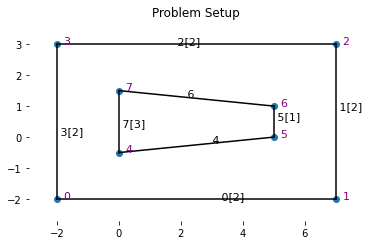

In [100]:
g = cfg.Geometry()

g.point([-2, -2])
g.point([7, -2])
g.point([7, 3])
g.point([-2, 3])

g.point([0.0, -0.5])
g.point([5.0, 0.0])
g.point([5.0, 1.0])
g.point([0.0, 1.5])

g.spline([0, 1], marker=2)
g.spline([1, 2], marker=2)
g.spline([2, 3], marker=2)
g.spline([3, 0], marker=2)

g.spline([4, 5], marker=0)
g.spline([5, 6], marker=1)
g.spline([6, 7], marker=0)
g.spline([7, 4], marker=3)

g.surface([0, 1, 2, 3], [[4, 5, 6, 7]])
g.surface([4, 5, 6, 7])

cfv.draw_geometry(g, title="Problem Setup")

k0 = 4

#### Generate Mesh

For FEM we need to discretize the domain using a triangular mesh. This is done automatically using GMSH, an open source meshing generator. We have control on how coarse or fine to make the mesh through the SizeFactor parameter. boundary_lookup creates a lookup dict which returns the boundary type for a given node.

In [101]:
def boundary_lookup(bdofs):
    new_dict = {}
    for key, array in bdofs.items():
        if (key == 3):
            continue
        for elem in array:
            new_dict[elem - 1] = key
    return new_dict

Info    : GMSH -> Python-module


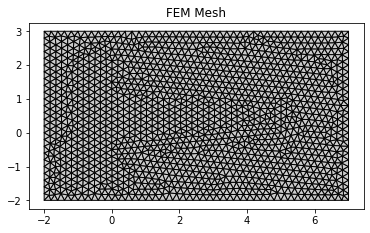

In [102]:
mesh = cfm.GmshMesh(g)
mesh.elType = 2
mesh.dofsPerNode = 1
mesh.elSizeFactor = 0.2
coords, edof, dofs, bdofs, elementMarkers = mesh.create()
num_elem = len(edof)
num_nodes = len(dofs)
boundaries = boundary_lookup(bdofs)

for n in range(num_nodes):
    if int(boundaries.get(n, 0)) == 1:
        boundaries[n] = np.sin(coords[n][1] * np.pi)

cfv.draw_mesh(coords=coords, edof=edof, dofs_per_node=mesh.dofs_per_node, el_type=mesh.el_type, filled=True, title="FEM Mesh")

#### Assemble Element Matrices

To begin the analysis, we must first assemble local matrices for each element which encode how the values at the nodes interact with one another. This formulation comes from the book "Introduction to the Finite Element
Method in Electromagnetics" by Anastasis C. Polycarpou.

The general method in 2D applies to any differential equation of the form:

$ \frac{\partial}{\partial x} (\alpha_x \frac{\partial u}{\partial x}) + \frac{\partial}{\partial y} (\alpha_y \frac{\partial u}{\partial y}) + \beta u = g$

Where $\alpha_x$, $\alpha_y$, $\beta$ and $g$ are constants that depend on the application and can be a function of $x$ and $y$. We are interested in finding $u(x,y)$. To solve this, the problem must be discretized into a number of finite elements which may be polygons or triangles as shown below:

<image src="discretization.png" width=600></image>

The FEM formulation begins with finding a method to interpolate the unknown quantity $u(x,y)$ within each finite element. This is normally acheived by utilizing a linear combination of shape functions associated with each vertex. They usually have the property that they equal 1 at their associated vertex and are 0 at the other vertices of the element. Thus any point in between can be calculated as a sum of such shape functions:

$u(x,y) = \sum_{j=1}^{n} u_j^e N_j (x,y)$

Where $u_i = u$ at each vertex $i$ and $N_i(x,y)$ is the shape function associated with each vertex $i$. In general these are 1st or 2nd order Lagrange polynomials.

FEM aims to minimise the residual of the differential equation over a single element:

$r^e = \frac{\partial}{\partial x} (\alpha_x \frac{\partial u}{\partial x}) + \frac{\partial}{\partial y} (\alpha_y \frac{\partial u}{\partial y}) + \beta u - g $

To do this we must integrate the resisdual over the element $\Omega$ and set this to zero. We also add a "weighting" function that enables for the equation to be converted into a matrix equation later on. 

$\iint_\Omega w (r^e) \, dx \, dy = 0$

$\iint_\Omega w (\frac{\partial}{\partial x} (\alpha_x \frac{\partial u}{\partial x}) + \frac{\partial}{\partial y} (\alpha_y \frac{\partial u}{\partial y}) + \beta u - g) \, dx \, dy = 0$

Through some manipulation (see book) this equation can be converted to.

$-\iint_\Omega [\alpha_x \frac{\partial w}{\partial x} \frac{\partial u}{\partial x} + \alpha_y \frac{\partial w}{\partial y} \frac{\partial u}{\partial y}] \, dx \, dy + \iint_\Omega \beta w u \, dx \, dy = \iint_\Omega w g \, dx \, dy - \oint_\Gamma w (\alpha_x \frac{\partial u}{\partial x} n_x + \alpha_y \frac{\partial u}{\partial y} n_y) d l$

The weighting functions are usually selected to be the shape functions themselves:

$w = N_i$ for $i = 1,2, ... n$

Now substituting the interpolated form of $u(x,y)$ and substituting in the weighting functions yields:

$-\iint_\Omega [\alpha_x \frac{\partial N_i}{\partial x} \frac{\partial (\sum_{j=1}^{n} u_j^e N_j (x,y))}{\partial x} + \alpha_y \frac{\partial N_i}{\partial y} \frac{\partial (\sum_{j=1}^{n} u_j^e N_j (x,y))}{\partial y}] \, dx \, dy + \iint_\Omega \beta N_i (\sum_{j=1}^{n} u_j^e N_j (x,y)) \, dx \, dy = \iint_\Omega N_i g \, dx \, dy - \oint_\Gamma N_i (\alpha_x \frac{\partial (\sum_{j=1}^{n} u_j^e N_j (x,y))}{\partial x} n_x + \alpha_y \frac{\partial (\sum_{j=1}^{n} u_j^e N_j (x,y))}{\partial y} n_y) d l$

for $ i = 1,2, ... n$

Which can be written in the matrix form:

$\begin{bmatrix}
M_{11} & M_{12} & \dots & M_{1n}\\
M_{21} & M_{22} & \dots & M_{2n}\\
\vdots & \vdots & \ddots & \vdots\\
M_{n1} & M_{n2} & \dots & M_{nn}
\end{bmatrix}$
$\begin{bmatrix}
u_1^e \\
u_2^e \\
\vdots \\
u_n^e 
\end{bmatrix}$ +
$\begin{bmatrix}
T_{11} & T_{12} & \dots & T_{1n}\\
T_{21} & T_{22} & \dots & T_{2n}\\
\vdots & \vdots & \ddots & \vdots\\
T_{n1} & T_{n2} & \dots & T_{nn}
\end{bmatrix}$ 
$\begin{bmatrix}
u_1^e \\
u_2^e \\
\vdots \\
u_n^e 
\end{bmatrix}$ = 
$\begin{bmatrix}
f_1^e \\
f_2^e \\
\vdots \\
f_n^e 
\end{bmatrix}$ +
$\begin{bmatrix}
p_1^e \\
p_2^e \\
\vdots \\
p_n^e 
\end{bmatrix}$

The values of each element are derived in the book and used in the code below. Once each of these matrices are constructed, the values for u_j can be found by solving the matrix.

In [103]:
def Me(coords, alpha_x, alpha_y):
    x1 = coords[0, 0]
    x2 = coords[1, 0]
    x3 = coords[2, 0]
    y1 = coords[0, 1]
    y2 = coords[1, 1]
    y3 = coords[2, 1]
    A = 1 / 2 * np.abs(x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    M11 = -(alpha_x * (y2 - y3) ** 2 + alpha_y * (x3 - x2) ** 2) / (4 * A)
    M12 = -(alpha_x * (y2 - y3) * (y3 - y1) + alpha_y * (x3 - x2) * (x1 - x3)) / (4 * A)
    M13 = -(alpha_x * (y2 - y3) * (y1 - y2) + alpha_y * (x3 - x2) * (x2 - x1)) / (4 * A)
    M22 = -(alpha_x * (y3 - y1) ** 2 + alpha_y * (x1 - x3) ** 2) / (4 * A)
    M23 = -(alpha_x * (y3 - y1) * (y1 - y2) + alpha_y * (x1 - x3) * (x2 - x1)) / (4 * A)
    M33 = -(alpha_x * (y1 - y2) ** 2 + alpha_y * (x2 - x1) ** 2) / (4 * A)
    return np.matrix(
        [[M11, M12, M13], [M12, M22, M23], [M13, M23, M33]], dtype="complex"
    )

In [104]:
def Te(coords, beta):
    x1 = coords[0, 0]
    x2 = coords[1, 0]
    x3 = coords[2, 0]
    y1 = coords[0, 1]
    y2 = coords[1, 1]
    y3 = coords[2, 1]
    A = 1 / 2 * np.abs(x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    T1 = beta * A / 6
    T2 = beta * A / 12
    return np.matrix([[T1, T2, T2], [T2, T1, T2], [T2, T2, T1]], dtype="complex")

In [105]:
def pe(coords, gamma, is_open):
    if not is_open:
        return np.matrix([[0, 0, 0], [0, 0, 0], [0, 0, 0]], dtype="complex")
    x1 = coords[0, 0]
    x2 = coords[1, 0]
    y1 = coords[0, 1]
    y2 = coords[1, 1]
    l12 = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    k11 = -gamma * l12 / 3
    k12 = -gamma * l12 / 6
    return np.matrix([[k11, k12, 0], [k12, k11, 0], [0, 0, 0]], dtype="complex")

In [106]:
ke = np.zeros((num_elem, 3, 3), dtype="complex")
be = np.zeros((num_elem, 3), dtype="complex")
for i in range(num_elem):
    is_open = False
    if boundaries.get(edof[i][0] - 1, 0) == 2 and boundaries.get(edof[i][1] - 1, 0) == 2:
        is_open = True
    ke[i] = (
        Me(coords[edof[i] - 1], 1, 1)
        + Te(coords[edof[i] - 1], k0 ** 2)
        + pe(coords[edof[i] - 1], 1j * k0, is_open)
    )

#### Assemble Global Matrix

The local element matrices must then be merged together to form the global matrix.

In [107]:
K = np.zeros((num_nodes, num_nodes), dtype="complex")
for e in range(num_elem):
    for i in range(3):
        for j in range(3):
            K[edof[e, i] - 1, edof[e, j] - 1] += ke[e, i, j]

#### Create RHS Vector

In [108]:
b = np.zeros(num_nodes, dtype=complex)

#### Introduce Boundary Conditions

Once the global matrix is formed, we must the introduce boundary conditions. This involves deleting certain rows and columns and slightly adjusting the right hand side vector.

In [109]:
to_delete = []
for n in range(num_nodes):
    if int(boundaries.get(n, 2)) == 2:
        continue
    for i in range(num_nodes):
        b[i] -= boundaries[n] * K[i, n]
    to_delete.append(n)
b = np.delete(b, to_delete, axis=0)
K = np.delete(K, to_delete, axis=0)
K = np.delete(K, to_delete, axis=1)

#### Solve

In [110]:
x = np.linalg.solve(K, b)

#### Cleanup Results

In [111]:
to_delete.sort()
for i in range(len(to_delete)):
    x = np.insert(x, to_delete[i], boundaries[to_delete[i]])

#### Plot

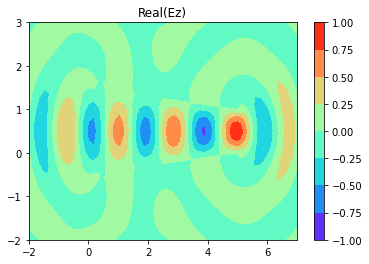

In [112]:
plt.figure()
plt.tricontourf(coords[:, 0], coords[:, 1], edof - 1, np.real(x), cmap=plt.cm.rainbow)
plt.title("Real(Ez)")
plt.colorbar()